In [128]:
pip install ipymarkup

Note: you may need to restart the kernel to use updated packages.


In [129]:
import numpy as np 
import pandas as pd 
import os
import torch
from torch import nn
import re
from tqdm import tqdm, tqdm_notebook
from torch.optim import Adam, AdamW
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
pd.options.mode.chained_assignment = None  # default='warn'
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score
from ipymarkup import show_span_box_markup

In [130]:
PATH1 = '/kaggle/input/rurebus-train-data/train_part_1/train_part_1'
PATH2 = '/kaggle/input/rurebus-train-data/train_part_2/train_part_2'
PATH3 = '/kaggle/input/rurebus-train-data/train_part_3/train_part_3'
PATH4 = '/kaggle/input/rurebus-train-data/test_ner_only' #чтобы все ок было надо обновить датасет до последней версии
# имена сущностей
NAMES = ['BIN', 'SOC', 'MET', 'CMP', 'ECO', 'INST', 'ACT', 'QUA']
# тэги для разметки
TAG = ['B-bin', 'I-bin', 'B-soc','I-soc','B-met', 'I-met','B-cmp','I-cmp','B-eco', 'I-eco','B-inst','I-inst','B-act','I-act','B-qua','I-qua']
RE_TAG = ['GOL', 'NNG', 'NNT', 'NPS', 'PNG', 'PNT', 'PPS', 'FNG', 'FNT', 'FPS']

**Задача**

Извлечение семантических отношений между сущностями (relation extraction, RE). В данной задаче заранее сущности заданы в тексте и требуется установить отношения между ними. Метрика оценивания -- микро F-мера.

In [131]:
# подготовка данных для обучения
def make_data(lst,path):        
    res_df = pd.DataFrame(columns = ['word', 'labels'])
    with tqdm(desc="n", total=len(lst)) as pbar_outer:
        for item in lst:
            #print(item)
            
            df1 = make_ann(item,path)
            df2 = make_rel(item,path)
            df3 = make_text(item, df1,df2,path)
            res_df = pd.concat([res_df, df3], ignore_index=True)
            pbar_outer.update(1)
    return res_df


# продготовка аннотаций
def make_ann(file,path):
    # открываю файл
    ann_df = pd.read_csv(path+'/'+file+'.ann', sep='\t', engine='python', header=None, on_bad_lines='skip') # здесь добавлено скипанье плохих строк(если например столбцов 6, а в трок только 4), наверно это не оч хорошо надо что-то придумать
    # нормальные названия для столбцов
    ann_df.rename(columns = {1:'class', 2:'words'}, inplace = True )
    # разделяю в разные столбцы классы и координаты
    ann_df.insert(2, 'coords' , ann_df['class'])
    ann_df['class'] = ann_df['class'].apply(lambda x: x.split(" ")[0])
    ann_df['coords'] = ann_df['coords'].apply(lambda x: x.split(" ")[1:])
    # удаляю нафиг строки с отношениями
    ann_df = ann_df.dropna()
    ann_df.reset_index(drop= True , inplace= True )
    # для удобства
    ann_df.insert(2, 'coords1' , ann_df['coords'])
    ann_df['coords1'] = ann_df['coords1'].apply(lambda x: int(x[0]))
    ann_df['words'] = ann_df['words'].apply(lambda x: my_split(x.split(" ")))
    ann_df['words'] = ann_df['words'].apply(lambda x: del_all(x))
    ann_df['words'] = ann_df['words'].apply(lambda x: [item.strip() for item in x if item not in ['','»', '«',':',' ']])
    ann_df = ann_df.sort_values(by='coords1')
    ann_df.reset_index(drop= True , inplace= True )
    return ann_df

def make_rel(file,path):
    new_df = pd.read_csv(path+'/'+file+'.ann', sep='\t', engine='python', header=None, on_bad_lines='skip') 
    new_df.rename(columns = {1:'class', 2:'words'}, inplace = True )
    new_df[0] = new_df[0].apply(lambda x: x if x.find('R') != -1 else 1)
    new_df = new_df[new_df[0]!=1]
    new_df.insert(2, 'arg1' , new_df['class'].copy())
    new_df.insert(3, 'arg2' , new_df['class'].copy())
    new_df['arg1'] = new_df['arg1'].apply(lambda x: x.split()[1][5:])
    new_df['arg2'] = new_df['arg2'].apply(lambda x: x.split()[2][5:])
    new_df['class'] = new_df['class'].apply(lambda x: x.split()[0])
    del new_df['words'] 
    new_df.reset_index(drop = True, inplace= True)
    return(new_df)

# разметка
def make_text(file, df,rel_df,path):
    # открываем файл и записываем его в dataframe
    with open(path+'/'+file+'.txt') as f:
        lines = f.readlines()
    text_df = pd.DataFrame({'word':lines})
    # считаем длины строк для удобства дальнейшей разметки
    text_df.insert(1, 'len' , text_df['word'].copy())
    text_df['len'] = text_df['len'].apply(lambda x: len(x)) # считаем длину строки
    new_lens = [text_df['len'][0]] # считаем длину предыдущих строк + длина новой строки
    for i in range(1, len(list(text_df['len']))):
        new_lens.append(sum(list(text_df['len'])[:i+1]))
    text_df.insert(2, 'new_len' , new_lens)
    # добавляем столбец для классов
    text_df.insert(3, 'labels', 0)
    # удаляем \n
    text_df['word'] = text_df['word'].apply(lambda x: re.split('\n',x)[0])
    #удаляем строрки с []
    idx = [i for i in range(len(text_df)) if len(text_df['word'][i])==0]
    text_df = text_df.drop(index=idx)
    text_df.reset_index(drop = True, inplace= True)
    # делаем разметку
    # находим индекс строки для каждой аннотации
    df = find_rows(text_df, df)
    # преобразовываем строку в массив
    text_df['word'] = text_df['word'].apply(lambda x: my_split([item for item in re.split(' ',x) if item != '']))
    text_df['word'] = text_df['word'].apply(lambda x: del_all(x))
    text_df['word'] = text_df['word'].apply(lambda x: [item.strip() for item in x if item not in ['',' ']])
    # момент разметки
    text_df = make_markup(text_df, df,rel_df)
    # удаляем лишнее
    del text_df['len']
    del text_df['new_len']
    text_df['word'] = text_df['word'].apply(lambda x: [item.lower() for item in x if item not in ['',' ']])
    idx = [i for i in range(len(text_df)) if len(text_df['word'][i])==0]
    text_df = text_df.drop(index=idx)
    text_df.reset_index(drop = True, inplace= True)
    return text_df


# отделяем все что можно
def my_split(lst):
    for k in range(3):
        for i in range(len(lst)-1,-1,-1):
            if lst[i] in ['',' ']:
                lst.pop(i)
            else:
                lst[i] = lst[i].replace('\xa0', ' ')
                lst[i] = lst[i].replace('\t', ' ')
                lst[i] = lst[i].replace('………………','')
                lst[i] = lst[i].replace('………','')
                lst[i] = lst[i].replace('……','')
                idx = []
                lens = len(lst[i])
                for item in ['+', ')', '»',';','.',',', '"','(', '«',':',' ', '-\t','\\', '/','”','“','-','–','_________','*','№','%']:
                     idx.append(lst[i].find(item))
                for item in ['\xa0','"','.']:
                    if lst[i].endswith(item) and lens-1 not in idx:
                        idx.append(lens-1)                    
                idx.sort(reverse=True)
                for item in idx:
                    if item!=-1 and item!=0:
                        lst.insert(i+1, lst[i][item])
                        lst.insert(i+2, lst[i][item+1:])
                        lst[i] = lst[i][:item]
                    elif item!=-1 and item == 0:
                        lst.insert(i+1, lst[i][item+1:])
                        lst[i] = lst[i][item]
                    elif item!= -1 and item == lens-1:
                        lst.insert(i+1, lst[i][item])
                        lst[i] = lst[i][:item] 
    return lst


def del_all(lst):
    for i in range(len(lst)-1,-1,-1):
        split = lst[i]
        split = split.split(' ')
        if len(split) >1:
            for j in range(len(split)):
                lst.insert(i+1+j, split[j])
            lst.pop(i)
    return lst

# находим индекс строки для каждой аннотации
def find_rows(txt_df, ann_df):
    ann_df.insert(4, 'idx' , 0)
    for i in range(len(ann_df)):
        for j in range(len(txt_df)):
            start = txt_df['new_len'][j]-txt_df['len'][j]
            end = txt_df['new_len'][j]
            if int(ann_df['coords'][i][0]) in np.arange(start, end):
                ann_df['idx'][i] = j
                break
            else:
                pass
    return ann_df
    
# основная часть разметки
def make_markup(text_df, ann_df, rel_df):
    df = pd.DataFrame(columns = ["word", "len",'new_len','labels', 'idx'])
    for idx in range(len(rel_df)):
        row1 = ann_df[ann_df[0] == rel_df['arg1'][idx]]
        row2 = ann_df[ann_df[0] == rel_df['arg2'][idx]]
        text = text_df['word'][row1['idx'].item()].copy() 
        if '<e1>' not in text:
            j = text.index(row1['words'].item()[0])
            text.insert(j, '<e1>')
            text.insert(j+len(row1['words'].item())+1, '</e1>')
            k = text.index(row2['words'].item()[0])
            text.insert(k, '<e2>')
            text.insert(k+len(row2['words'].item())+1, '</e2>')
            text_df['word'][row1['idx'].item()] = text
            text_df['labels'][row1['idx'].item()] = rel_df['class'][idx]
        else:
            text.remove('<e1>')
            text.remove('</e1>')
            text.remove('<e2>')
            text.remove('</e2>')
            j = text.index(row1['words'].item()[0])
            text.insert(j, '<e1>')
            text.insert(j+len(row1['words'].item())+1, '</e1>')
            k = text.index(row2['words'].item()[0])
            text.insert(k, '<e2>')
            text.insert(k+len(row2['words'].item())+1, '</e2>')
            new_row = pd.DataFrame({"word": ['a'], "len": 0, 'new_len':0, 'labels':rel_df['class'][idx], 'idx':row1['idx'].item()+1})
            df = pd.concat([df,new_row], ignore_index=True).reset_index(drop=True)
            df['word'][len(df)-1] = text  
    if len(df) !=0:
        df.sort_values(by='idx', ascending=False)
        for i in range(len(df)-1, -1,-1):
            row = pd.DataFrame({"word": ['a'], "len": 0, 'new_len':0, 'labels':df['labels'][i]})
            text_df = pd.concat([text_df.iloc[:df['idx'][i]], row, text_df.iloc[df['idx'][i]:]]).reset_index(drop=True)
            text_df['word'][df['idx'][i]] = df['word'][i] 
    text_df = text_df[text_df['labels']!=0]
    text_df=text_df.reset_index(drop=True)
    return text_df

In [132]:
# список всех файлов для обучения
data_lst = list(set([item[:-4] for item in os.listdir(PATH1)]))
data_lst.remove('.stats_c')
data_lst.remove('31339011023301254426027_6_part_0')
data_lst.remove('32339091024501206520016_20_part_1')
data_lst.remove('31339011024501815733001_11_part_0')
train_df = make_data(data_lst, PATH1)
train_df.head()

n: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]


,word,labels
0,"[<e1>, создание, </e1>, новых, <e2>, объектов,...",TSK
1,"[создание, новых, <e2>, объектов, транспортной...",TSK
2,"[<e1>, повышение, </e1>, <e2>, доступности, тр...",TSK
3,"[<e1>, содействие, </e1>, <e2>, занятости, нас...",TSK
4,"[цель, подпрограммы, -, <e1>, содействие, </e1...",TSK


In [133]:
len(train_df)

4466

In [134]:
#файлы для валидации
data_lst = list(set([item[:-4] for item in os.listdir(PATH2)]))
data_lst = data_lst[0]
val_df = make_data([data_lst], PATH2)
val_df.head()

n: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


,word,labels
0,"[прогноз, социально, -, экономического, развит...",TSK
1,"[в, связи, с, <e2>, отсутствием, </e2>, некото...",NNG
2,"[в, связи, с, отсутствием, некоторых, показате...",NNT
3,"[в, отчетном, периоде, на, территории, мо, мр,...",NPS
4,"[демографическая, ситуация, в, мр, «, койгород...",NNG


In [135]:
from ipymarkup import show_dep_markup
words = train_df.iloc[33,0][:29]
deps = [(21, 22, 'gol'), (21, 24, 'gol')]
show_dep_markup(words, deps)

In [136]:
vocab = build_vocab_from_iterator(train_df['word'], min_freq=1, specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])
vocab_lables = build_vocab_from_iterator([train_df['labels']], min_freq=1, specials=["<UNK>"])

In [137]:
def make_tl(df):
    tokens = []
    lables = []
    max_len = 0
    for ind in df.index:
        tokens.append(vocab(df['word'][ind]))
        lables.append(vocab_lables([df['labels'][ind]]))
        if len(df['word'][ind]) > max_len:
            max_len = len(df['word'][ind])
    df['tokens'] = tokens
    df['lables'] = lables
    return df,max_len


def make_pad(df):
    list_sent = []
    list_labels = []
    for ind in df.index:
        list_sent.append(df['tokens'][ind])
        list_labels.append(df['lables'][ind])
    #print(list_sent)
    padded_sent = pad_sequences(list_sent)
    #padded_labels = pad_sequences(list_labels)
    print(padded_sent.shape)
    padd_df = pd.DataFrame(columns = ['sentence', 'labels'])
    padd_df['sentence'] = pd.Series(padded_sent.tolist())
    padd_df['labels'] = pd.Series(list_labels)
    return padd_df

In [138]:
train_df, max_len1 = make_tl(train_df)
val_df, max_len2 = make_tl(val_df)
train_df

,word,labels,tokens,lables
0,"[<e1>, создание, </e1>, новых, <e2>, объектов,...",TSK,"[7, 66, 5, 225, 8, 55, 322, 70, 6, 1, 1370, 67...",[1]
1,"[создание, новых, <e2>, объектов, транспортной...",TSK,"[66, 225, 8, 55, 322, 70, 6, 1, 7, 1370, 5, 67...",[1]
2,"[<e1>, повышение, </e1>, <e2>, доступности, тр...",TSK,"[7, 45, 5, 8, 282, 374, 35, 15, 20, 6, 2]",[1]
3,"[<e1>, содействие, </e1>, <e2>, занятости, нас...",TSK,"[7, 671, 5, 8, 709, 20, 6, 9, 33, 24, 32, 24, ...",[1]
4,"[цель, подпрограммы, -, <e1>, содействие, </e1...",TSK,"[779, 193, 10, 7, 671, 5, 8, 709, 20, 6, 2]",[1]
...,...,...,...,...
4461,"[оценка, эффективности, расходования, средств,...",TSK,"[1468, 47, 769, 38, 1, 2255, 9, 269, 21, 1, 17...",[1]
4462,"[порядок, поведения, и, критерии, <e1>, оценки...",GOL,"[1564, 666, 3, 8496, 7, 325, 5, 8, 47, 30, 77,...",[2]
4463,"[методика, <e1>, оценки, </e1>, <e2>, эффектив...",GOL,"[5746, 7, 325, 5, 8, 47, 30, 72, 227, 6, 4, 21...",[2]
4464,"[методика, оценки, <e2>, эффективности, <e1>, ...",GOL,"[5746, 325, 8, 47, 7, 30, 6, 5, 72, 227, 4, 21...",[2]


In [139]:
print(max_len1, ' ',max_len2)

306   61


In [140]:
# делаем паддинг 
train_df = make_pad(train_df)
val_df = make_pad(val_df)
train_df

(4466, 306)
(49, 61)


,sentence,labels
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1]
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1]
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1]
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1]
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1]
...,...,...
4461,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1]
4462,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[2]
4463,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[2]
4464,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[2]


In [141]:
#train_df['labels'] = train_df['labels'].apply(lambda x: x[0])
#val_df['labels'] = val_df['labels'].apply(lambda x: x[0])
#train_df

In [142]:
print(len(train_df['sentence'][4]),len(val_df['sentence'][4]))

306 61


In [143]:
def one_hot(x: np.ndarray, vocab_len: int) -> np.ndarray:
    """
    Args:
        x - одномерный массив значений словаря
        vocab_len - длина словаря
    Выход:
        двумерный массив encoded, где encoded[i] - результат one hot кодирования x[i]
    """
    encoded = np.zeros((len(x), vocab_len))
    for i in range(len(x)):
        encoded[i][x[i]] = 1
    return encoded[0]

text_vocab_len = len(vocab)
target_vocab_len = len(vocab_lables)

class TokenDataset(torch.utils.data.Dataset):
    def __init__(self, data, text_vocab_len = text_vocab_len, target_vocab_len = target_vocab_len, classes = None,
                 transform=None, target_transform=None):
        self.data = data
        self.sequence_len = len(data.iloc[0][0])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        tokens, tag = self.data.iloc[idx]
        return torch.Tensor(tokens).int(), torch.Tensor(one_hot(tag, target_vocab_len))
        # return torch.Tensor(tokens).int(), torch.Tensor(tag)

In [144]:
datasets = {
    'train': TokenDataset(train_df),
    'val': TokenDataset(val_df)
}

In [145]:
dataloader = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=16,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=16,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [146]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [147]:
import math
class CustomLSTM(nn.Module):
    def __init__(self, input_sz, hidden_sz):
        super().__init__()
        self.input_sz = input_sz
        self.hidden_size = hidden_sz
        self.W = nn.Parameter(torch.Tensor(input_sz, hidden_sz * 4))
        self.U = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz * 4))
        self.bias = nn.Parameter(torch.Tensor(hidden_sz * 4))
        self.init_weights()
                
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
         
    def forward(self, x, 
                init_states=None):
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = (torch.zeros(bs, self.hidden_size).to(x.device), 
                        torch.zeros(bs, self.hidden_size).to(x.device))
        else:
            h_t, c_t = init_states
         
        HS = self.hidden_size
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            gates = x_t @ self.W + h_t @ self.U + self.bias
            i_t, f_t, g_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.tanh(gates[:, HS*2:HS*3]),
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [148]:
class CNN_LSTM_old(nn.Module):
    def __init__(self, vocab_size, n_classes, embedding_dim=250, hidden_size = 32, filters=((2, 10), (3, 8))):
        super().__init__()
        
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=200, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool1d(2)
        input_size = 100
        self.hidden_size = hidden_size
        self.lstm_layer = CustomLSTM(input_size, hidden_size)
        self.fc = nn.Linear(self.hidden_size, n_classes)
        outputs = []

    def forward(self, inputs):
        projections = self.embeddings_layer.forward(inputs) 
        projections = projections.transpose(1, 2)
        projections = self.conv1(projections)
        projections = projections.transpose(1, 2)
        projections = self.pool1(projections)
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        output = output.reshape(-1, self.hidden_size)
        output = self.fc(output)
        return output

In [149]:
class CNN_LSTM(nn.Module):
    def __init__(self, vocab_size, n_classes, embedding_dim=250, hidden_size = 32, filters=((2, 10), (3, 8))):
        super().__init__()
        
        self.embeddings_layer = nn.Embedding(vocab_size, embedding_dim)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=200, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool1d(2)
        input_size = 100
        self.hidden_size = hidden_size
        self.lstm_layer = CustomLSTM(input_size, hidden_size)
        self.fc = nn.Linear(self.hidden_size, n_classes)
        outputs = []

    def forward(self, inputs):
        projections = self.embeddings_layer.forward(inputs) 
        projections = projections.transpose(1, 2)
        projections = self.conv1(projections)
        projections = projections.transpose(1, 2)
        projections = self.pool1(projections)
        output, (final_hidden_state, final_cell_state) = self.lstm_layer(projections)
        output = self.fc(final_hidden_state)
        return output

In [150]:
def train_model(model, criterion, optimizer, num_epochs=3):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    loss_list = {'train' : [], 'val':[]}
    acc_list = {'train' : [], 'val':[]}
    f1_list = {'train' : [], 'val':[]}
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                    step_size=10,
#                                                    gamma=0.2)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                print('start train')
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            all_true_labels = []
            all_preds = []
            inputs_str = []
            for inputs, labels in tqdm(dataloader[phase]):
                batch_size, n_classes = labels.shape
                labels = labels.to(device)
                outputs = model(inputs.to(device))
                # print(outputs, labels)
#                 print(outputs.shape, labels.shape)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() #* inputs.size(0)
                _, labels = torch.max(labels, 1)
#                 print()
#                 print(preds, labels)
                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())
            epoch_loss = running_loss /len(dataloader[phase])
            epoch_acc = accuracy_score(all_preds, all_true_labels)
            epoch_f1 = f1_score(all_preds, all_true_labels, average='micro')
#             lr_scheduler.step()  
            print('{} loss: {:.4f}, acc: {:.4f}, f1: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc,
                                                        epoch_f1            
                                                        ))
            loss_list[phase].append(epoch_loss)
            acc_list[phase].append(epoch_acc.tolist())
            f1_list[phase].append(epoch_f1.tolist())
    return all_true_labels, all_preds, inputs_str, loss_list, acc_list, f1_list

In [151]:
n_classes = len(vocab_lables)
model = CNN_LSTM(len(vocab), n_classes = n_classes).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr = 3e-4)

In [152]:
epox_num = 15
all_true_labels, all_preds, inputs_str, loss, acc, f1 = train_model(model, criterion, optimizer, epox_num)

Epoch 1/15
----------
start train


100%|██████████| 280/280 [01:04<00:00,  4.34it/s]


train loss: 1.7414, acc: 0.4758, f1: 0.4758


100%|██████████| 4/4 [00:00<00:00, 57.84it/s]


val loss: 2.5361, acc: 0.2245, f1: 0.2245
Epoch 2/15
----------
start train


100%|██████████| 280/280 [01:03<00:00,  4.38it/s]


train loss: 1.3794, acc: 0.5661, f1: 0.5661


100%|██████████| 4/4 [00:00<00:00, 52.03it/s]


val loss: 2.3008, acc: 0.3265, f1: 0.3265
Epoch 3/15
----------
start train


100%|██████████| 280/280 [01:04<00:00,  4.35it/s]


train loss: 1.0869, acc: 0.6735, f1: 0.6735


100%|██████████| 4/4 [00:00<00:00, 55.97it/s]


val loss: 2.1561, acc: 0.3061, f1: 0.3061
Epoch 4/15
----------
start train


100%|██████████| 280/280 [01:04<00:00,  4.36it/s]


train loss: 0.8766, acc: 0.7443, f1: 0.7443


100%|██████████| 4/4 [00:00<00:00, 57.23it/s]


val loss: 2.2243, acc: 0.3673, f1: 0.3673
Epoch 5/15
----------
start train


100%|██████████| 280/280 [01:03<00:00,  4.40it/s]


train loss: 0.7024, acc: 0.8059, f1: 0.8059


100%|██████████| 4/4 [00:00<00:00, 55.62it/s]


val loss: 2.0457, acc: 0.3265, f1: 0.3265
Epoch 6/15
----------
start train


100%|██████████| 280/280 [01:04<00:00,  4.34it/s]


train loss: 0.5908, acc: 0.8370, f1: 0.8370


100%|██████████| 4/4 [00:00<00:00, 56.45it/s]


val loss: 2.2617, acc: 0.3673, f1: 0.3673
Epoch 7/15
----------
start train


100%|██████████| 280/280 [01:06<00:00,  4.22it/s]


train loss: 0.4871, acc: 0.8692, f1: 0.8692


100%|██████████| 4/4 [00:00<00:00, 50.28it/s]


val loss: 2.2810, acc: 0.3061, f1: 0.3061
Epoch 8/15
----------
start train


100%|██████████| 280/280 [01:06<00:00,  4.22it/s]


train loss: 0.4137, acc: 0.8925, f1: 0.8925


100%|██████████| 4/4 [00:00<00:00, 51.33it/s]


val loss: 2.4752, acc: 0.3265, f1: 0.3265
Epoch 9/15
----------
start train


100%|██████████| 280/280 [01:05<00:00,  4.29it/s]


train loss: 0.3416, acc: 0.9113, f1: 0.9113


100%|██████████| 4/4 [00:00<00:00, 55.78it/s]


val loss: 2.4350, acc: 0.3061, f1: 0.3061
Epoch 10/15
----------
start train


100%|██████████| 280/280 [01:04<00:00,  4.33it/s]


train loss: 0.3097, acc: 0.9172, f1: 0.9172


100%|██████████| 4/4 [00:00<00:00, 51.60it/s]


val loss: 2.5889, acc: 0.3061, f1: 0.3061
Epoch 11/15
----------
start train


100%|██████████| 280/280 [01:06<00:00,  4.20it/s]


train loss: 0.2658, acc: 0.9306, f1: 0.9306


100%|██████████| 4/4 [00:00<00:00, 51.84it/s]


val loss: 2.5346, acc: 0.3673, f1: 0.3673
Epoch 12/15
----------
start train


100%|██████████| 280/280 [01:06<00:00,  4.19it/s]


train loss: 0.2284, acc: 0.9416, f1: 0.9416


100%|██████████| 4/4 [00:00<00:00, 51.61it/s]


val loss: 2.5316, acc: 0.3061, f1: 0.3061
Epoch 13/15
----------
start train


100%|██████████| 280/280 [01:05<00:00,  4.30it/s]


train loss: 0.2205, acc: 0.9425, f1: 0.9425


100%|██████████| 4/4 [00:00<00:00, 59.13it/s]


val loss: 2.8781, acc: 0.3469, f1: 0.3469
Epoch 14/15
----------
start train


100%|██████████| 280/280 [01:04<00:00,  4.32it/s]


train loss: 0.2018, acc: 0.9458, f1: 0.9458


100%|██████████| 4/4 [00:00<00:00, 55.62it/s]


val loss: 2.8143, acc: 0.2857, f1: 0.2857
Epoch 15/15
----------
start train


100%|██████████| 280/280 [01:04<00:00,  4.33it/s]


train loss: 0.1745, acc: 0.9519, f1: 0.9519


100%|██████████| 4/4 [00:00<00:00, 54.91it/s]

val loss: 2.6788, acc: 0.3469, f1: 0.3469


In [153]:
epox_list = [i for i in range(epox_num)]
def graf(loss, acc):
    
    fig, ax = plt.subplots(2, 3, figsize=(26, 13))
    ax[0, 0].plot(epox_list, loss['train'])
    ax[0, 0].set_title("Изменение потерь на обучающей выборке")
    ax[0, 1].plot(epox_list, acc['train'])
    ax[0, 1].set_title("Изменение точности на обучающей выборке")
    ax[0, 2].plot(epox_list, f1['train'])
    ax[0, 2].set_title("Изменение f1-score на обучающей выборке")
    ax[1, 0].plot(epox_list, loss['val'])
    ax[1, 0].set_title("Изменение потерь на валидационной выборке")
    ax[1, 1].plot(epox_list, acc['val'])
    ax[1, 1].set_title("Изменение точности на валидационной выборке")
    ax[1, 2].plot(epox_list, f1['val'])
    ax[1, 2].set_title("Изменение f1-score на валидационной выборке")
    plt.show()

In [154]:
# убираем палдинги 
data = {'sentence': val_df['sentence'], 'real_cat': np.array_split(all_true_labels, len(val_df['sentence'])), 'pred_cat':np.array_split(all_preds, len(val_df['sentence']))}
df_val_see = pd.DataFrame(data)
for ind in df_val_see.index:
    sent = df_val_see['sentence'][ind]
    try:
        len_pad = sent.index(next(filter(lambda x: x!=0, sent)))
    except StopIteration:
        pass
    sent = sent[len_pad:]
    sent = vocab.lookup_tokens(sent)
    df_val_see.at[ind, 'sentence'] = sent 
    sent = df_val_see['real_cat'][ind]
    #sent = sent[len_pad:]
    sent = vocab_lables.lookup_tokens(sent)
    df_val_see.at[ind, 'real_cat'] = sent 
    sent = df_val_see['pred_cat'][ind]
    #sent = sent[len_pad:]
    sent = vocab_lables.lookup_tokens(sent)
    df_val_see.at[ind, 'pred_cat'] = sent
df_val_see

,sentence,real_cat,pred_cat
0,"[прогноз, социально, -, экономического, развит...",[TSK],[GOL]
1,"[в, связи, с, <e2>, отсутствием, </e2>, некото...",[NNG],[NNT]
2,"[в, связи, с, отсутствием, некоторых, показате...",[NNT],[NPS]
3,"[в, отчетном, периоде, на, территории, мо, мр,...",[NPS],[PNT]
4,"[демографическая, ситуация, в, мр, «, койгород...",[NNG],[NNG]
5,"[<e1>, численность, населения, </e1>, за, 2017...",[PNG],[NNT]
6,"[общее, <e2>, снижение, </e2>, <e1>, численнос...",[PNG],[NNG]
7,"[по, прогнозным, оценкам, в, 2019, -, 2021, го...",[FNG],[NNG]
8,"[причинами, <e2>, снижения, </e2>, <e1>, числе...",[FNG],[NNG]
9,"[к, концу, 2021, года, <e1>, численность, насе...",[FNG],[PNT]


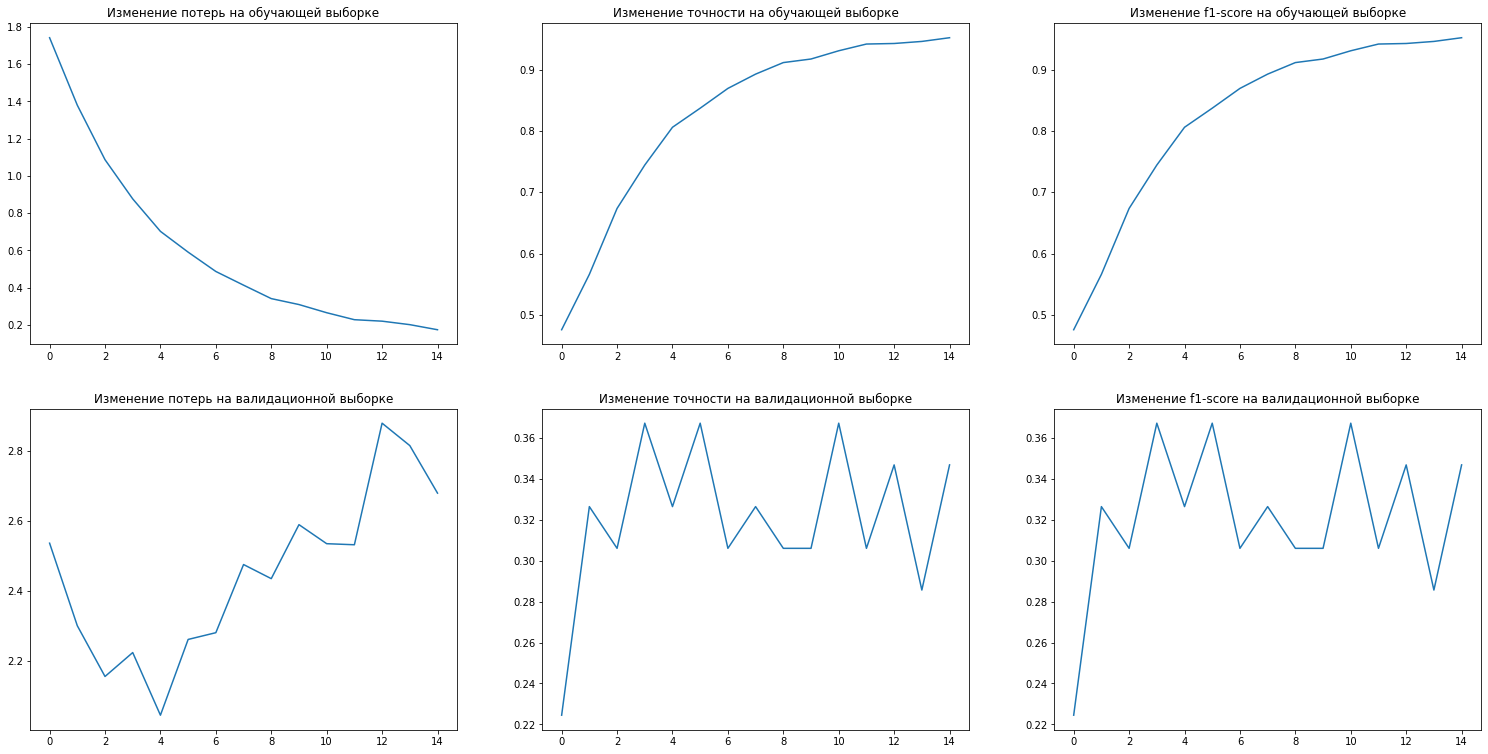

In [155]:
import matplotlib.pyplot as plt
graf(loss, acc)

In [156]:
def make_test(model,dataloader,dataset):
    all_true_labels = []
    all_preds = []
    inputs_str = []
    acc_list = []
    model.eval()
    for inputs, labels in tqdm(dataloader):
        batch_size, n_classes = labels.shape
        labels = labels.to(device)
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        _, labels = torch.max(labels, 1)
        all_true_labels.extend(labels.tolist())
        all_preds.extend(preds.tolist())
    epoch_acc = accuracy_score(all_preds, all_true_labels)
    epoch_f1 = f1_score(all_preds, all_true_labels, average='micro')
    print('acc: {:.4f}, f1: {:.4f}'.format(epoch_acc, epoch_f1))
    acc_list.append(epoch_acc.tolist())
    return all_true_labels, all_preds

In [157]:
data_lst = list(set([item[:-4] for item in os.listdir(PATH3)]))
data_lst.remove('35339031055006363114008_28_part_1')
data_lst.remove('31339061024501948020025_29_part_0')
data_lst.remove('31228011026200851214048_3_part_0')
test_df = make_data(data_lst[:100], PATH3)
test_df, max_len1 = make_tl(test_df)
test_df = make_pad(test_df)

n: 100%|██████████| 48/48 [01:10<00:00,  1.47s/it]


(4832, 249)


In [158]:
dataset =  TokenDataset(test_df)
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=0)
all_t,all_p = make_test(model,test_dataloader,dataset)

100%|██████████| 2416/2416 [02:35<00:00, 15.52it/s]

acc: 0.3075, f1: 0.3075


In [159]:
# убираем палдинги 
data = {'sentence': test_df['sentence'], 'real_cat': np.array_split(all_t, len(test_df['sentence'])), 'pred_cat':np.array_split(all_p, len(test_df['sentence']))}
df_test_see = pd.DataFrame(data)
df_test_see


,sentence,real_cat,pred_cat
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[4],[1]
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[10],[2]
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[5],[1]
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[3],[3]
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[11],[1]
...,...,...,...
4827,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[1],[4]
4828,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[4],[1]
4829,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[4],[1]
4830,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[4],[1]


In [160]:
for ind in df_test_see.index:
    sent = df_test_see['sentence'][ind]
    try:
        len_pad = sent.index(next(filter(lambda x: x!=0, sent)))
    except StopIteration:
        pass
    sent = sent[len_pad:]
    sent = vocab.lookup_tokens(sent)
    df_test_see.at[ind, 'sentence'] = sent 
    sent = df_test_see['real_cat'][ind]
    #sent = sent[len_pad:]
    sent = vocab_lables.lookup_tokens(sent)
    df_test_see.at[ind, 'real_cat'] = sent 
    sent = df_test_see['pred_cat'][ind]
    #sent = sent[len_pad:]
    sent = vocab_lables.lookup_tokens(sent)
    df_test_see.at[ind, 'pred_cat'] = sent 
df_test_see

,sentence,real_cat,pred_cat
0,"[мероприятия, программы, <UNK>, субъекты, сист...",[FPS],[TSK]
1,"[<e1>, открытие, </e1>, <e2>, <UNK>, «, <UNK>,...",[FNT],[GOL]
2,"[кроме, того, ,, 37, детей, ,, проживающих, на...",[NNT],[TSK]
3,"[причинами, <e2>, недостаточного, </e2>, <e1>,...",[NNG],[NNG]
4,"[причинами, недостаточного, охвата, детей, дош...",[PNG],[TSK]
...,...,...,...
4827,"[одновременно, с, реализацией, инвестиционных,...",[TSK],[FPS]
4828,"[ооо, «, <UNK>, <UNK>, », <UNK>, <UNK>, <UNK>,...",[FPS],[TSK]
4829,"[ооо, «, <UNK>, <UNK>, <UNK>, », предлагается,...",[FPS],[TSK]
4830,"[ооо, «, <UNK>, <UNK>, <UNK>, », предлагается,...",[FPS],[TSK]


In [161]:
ll = df_test_see[df_test_see['real_cat'] == df_test_see['pred_cat']]
ll

,sentence,real_cat,pred_cat
3,"[причинами, <e2>, недостаточного, </e2>, <e1>,...",[NNG],[NNG]
8,"[для, обеспечения, <UNK>, <UNK>, возможностей,...",[TSK],[TSK]
19,"[для, обеспечения, <UNK>, <UNK>, возможностей,...",[TSK],[TSK]
23,"[в, системе, общего, образования, <UNK>, муниц...",[NNT],[NNT]
28,"[в, сети, учреждений, есть, школы, ,, <UNK>, <...",[NNG],[NNG]
...,...,...,...
4821,"[основными, факторами, ,, влияющими, на, форми...",[TSK],[TSK]
4822,"[3, ., <e1>, расширение, </e1>, <e2>, спроса, ...",[TSK],[TSK]
4824,"[на, i, этапе, (, 2013, -, 2015, годы, ), буду...",[TSK],[TSK]
4825,"[«, <UNK>, <UNK>, », <UNK>, <e1>, реализовать,...",[TSK],[TSK]


In [162]:
df_test_see['sentence'][4820], df_test_see['real_cat'][4820], df_test_see['pred_cat'][4820]

(['основными',
  'факторами',
  ',',
  'влияющими',
  'на',
  'формирование',
  'условий',
  'для',
  '<UNK>',
  'на',
  'рынок',
  '<UNK>',
  'продукции',
  ',',
  'являются',
  'ускорение',
  '<UNK>',
  'результатов',
  'научно',
  '-',
  'технической',
  'деятельности',
  ',',
  'развитие',
  '<UNK>',
  'предпринимательства',
  'в',
  '<UNK>',
  'детских',
  'товаров',
  ',',
  'использование',
  'действующей',
  'инфраструктуры',
  'поддержки',
  '<UNK>',
  ',',
  '<e1>',
  'исследование',
  '</e1>',
  '<e2>',
  'перспективных',
  'рынков',
  '</e2>',
  ',',
  'создание',
  'новых',
  'продуктов',
  '.'],
 ['TSK'],
 ['TSK'])